In [1]:
import sys
sys.path.append("..\\") # parent directory

from AQUA_general import AQUA
from batchAQUA_general import batchAQUA
from plotting_functions import *
from stimulus import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import CLI
import CF
import simulation
from functions import *

In [2]:
conf = CF.read_conf("RS_resonator_config.ini")


In [3]:
# Lines 47-68
# neuron params to be used for every simulation below
params = simulation.cast_to_float(conf["Neuron"])

# extract autapse params
f_vals   = np.array(conf["Autapse"]["f"].split(", "), dtype = np.float64)
e_vals   = np.array(conf["Autapse"]["e"].split(", "), dtype = np.float64)
tau_vals = np.array(conf["Autapse"]["tau"].split(", "), dtype = np.float64)

# calculate the number of neurons
N_neurons = 1 + len(f_vals) * len(e_vals) * len(tau_vals)
# params arr will store all the parameter dictionaries in 1 place.
params_arr = []
params_arr.append(params) # index 0, will be the reference non-autaptic neuron
for f in f_vals:
    for e in e_vals:
        for tau in tau_vals:
            temp_dict = params
            temp_dict["f"] = f
            temp_dict["e"] = e
            temp_dict["tau"] = tau

            params_arr.append(temp_dict)

#### FIRST TEST


In [4]:
# From first_test

print("SIMULATION 1")
# Define the simulation params
T = float(conf['Simulation 1']['T'])        # needs to be in ms
dt = float(conf['Simulation 1']['dt'])      # ms
N_iter = int(1000*T/dt)                          # number of iterations

print("Finding threshold...")
threshold, x_ini = find_threshold(params_arr[0], np.linspace(0, 500, 100), T, dt)

# extract frequencies to investigate
freq_start = float(conf["Simulation 1"]["freq_start"])
freq_stop = float(conf["Simulation 1"]["freq_stop"])
N_freq = int(conf["Simulation 1"]["N_freq"])
freq_range = np.linspace(freq_start, freq_stop, N_freq)

pulse_duration = float(conf["Simulation 1"]["pulse_duration"])

N_pulses = 2    
delay = float(conf["Simulation 1"]["delay"])          # ms
pulse1_end = delay + pulse_duration

print("Finding pulse height...")
# the height of the pulse which produces a spike and the relative timing of the spike.
pulse_height, time_to_spike = find_pulse_height(params_arr[0], np.linspace(100, 1000, 100), threshold, x_ini, pulse_duration)

# define the frequency of the pulses relative to the spike timing.
ISI_range = time_to_spike + 1000/freq_range

# Define the injected current
# structure: 0:N_neurons @ a given isi, increment isi and define N_neurons more neurons...
I_inj = np.array([spikes_constant(N_iter, dt, threshold, isi, N_pulses, pulse_height, pulse_duration, delay) for isi in ISI_range for n in range(N_neurons)])
N_sims = np.shape(I_inj)[0]     # N_neurons x N_isis

# define batch now that we know how many simulations are run
batch1_params = []
for i in range(N_freq):
    batch1_params += params_arr
x_start = np.full((N_sims, 3), fill_value = x_ini)
t_start = np.zeros(N_sims)
# define and initialize

batch1 = batchAQUA(batch1_params)
batch1.Initialise(x_start, t_start)

X, T, spikes = batch1.update_batch(dt, N_iter, I_inj)

SIMULATION 1
Finding threshold...


  0%|          | 0/4999 [00:00<?, ?it/s]

100%|██████████| 4999/4999 [00:00<00:00, 5972.30it/s]


Finding pulse height...


100%|██████████| 4999/4999 [00:09<00:00, 527.55it/s]


Resonant F
[  3.0465513    3.54937176   4.05613694   4.56537619   5.07768864
   5.59159025   6.10724319   6.62514907   7.15102975   7.67224183
   8.20075447   8.73057447   9.26440615   9.8000784   10.33698573
  10.87665869  11.42334933  11.97031362  12.5250501   13.06506402
  13.63512408  14.17635384  14.74056604  15.30456076  15.88814744
  16.4365549   17.02417433  17.59324419  18.16860465  18.74765654
  19.32740626  19.94415636  20.51702913  21.12378538  21.72024327
  22.3015165   22.9147571   23.56267672  24.13127413  24.78929103
  25.35496957  26.01456816  26.63825253  27.29257642  27.90178571
  28.53881279  29.20560748  29.81514609  30.45066991  31.11387679
  31.80661578  32.42542153  33.06878307  33.73819163  34.43526171
  35.0385424   35.79098067  36.44314869  37.11952487  37.8214826
  38.55050116  39.15426782  39.93610224  40.58441558  41.25412541
  42.12299916  42.84490146  43.40277778  44.16961131  44.96402878
  45.78754579  46.42525534  47.08097928  47.98464491  48.68549172


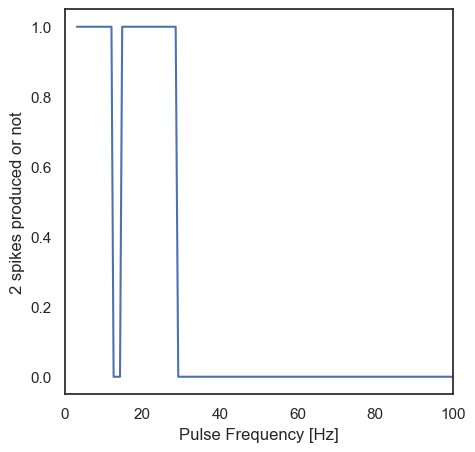

In [5]:
# Second part of first_test

pulse2_start  = np.zeros(N_sims)
spike_boolean = np.zeros(N_sims)

for n in range(N_sims):
    if len(spikes[n, np.isnan(spikes[n])]) != 1:        # if 2 spikes generated
        spike_boolean[n] = 1
    pulse_times = np.argwhere(I_inj[n, :] > threshold) * dt                     # pulse times in ms
    pulse2_start[n] = pulse_times[np.where(pulse_times > pulse1_end)][0]        # start time of the second pulse, ms

#InterPulse_Intervals = pulse2_start - pulse1_end
first_spike_time = pulse1_end + time_to_spike

resonant_ISI = (pulse2_start - first_spike_time).reshape((N_neurons, N_freq), order = 'F')
resonant_ISI = resonant_ISI[0, :]   # only take the first row as all rows are identical
resonant_f = 1000/resonant_ISI # represents the frequency of the pulses w.r.t the spike time
print("Resonant F")
print(resonant_f)


bands = spike_boolean.reshape((N_neurons, N_freq), order = 'F') # where 2 spikes were generated. Maps to the frequencies.
print(bands[0, :])


print("Resonance")
print(resonant_f[bands[0, :].astype(bool)])

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.plot(resonant_f, bands[0, :])
ax.set_xlabel("Pulse Frequency [Hz]")
ax.set_ylabel("2 spikes produced or not")
ax.set_xlim((0, 100))
plt.show()

In [6]:
resonance_bands = get_resonance_bands(resonant_f, bands[0, :])
print(resonance_bands)

largest_band_idx = np.argmax(np.diff(resonance_bands, axis = 1))
peak_resonance = np.mean(resonance_bands[largest_band_idx])
print(f"Peak Resonance: {peak_resonance}")

[[ 0.         11.97031362]
 [14.17635384 28.53881279]]
Peak Resonance: 21.357583313602273


#### SECOND TEST

In [7]:
N_neurons = np.shape(params_arr)[0]

# Define the simulation params
T = float(conf['Simulation 2']['T'])        # needs to be in ms
dt = float(conf['Simulation 2']['dt'])      # ms
N_iter = int(1000*T/dt)                          # number of iterations

print("Finding threshold...")
threshold, x_ini = find_threshold(params_arr[0], np.linspace(0, 500, 100), T, dt)

pulse_frequency = peak_resonance   # optimal resonance of base neuron model... good assumption?
pulse_ISI = 1000/pulse_frequency        # ms
pulse2_heights = np.linspace(10, 1000, 200)
pulse_duration = float(conf["Simulation 2"]["pulse_duration"])

# get the minimum pulse height that induces a spike if it arrives at the peak resonance frequency.
pulse2_height = find_2nd_pulse_height(params_arr[0], pulse2_heights, threshold, x_ini, pulse_duration, pulse_height, time_to_spike, pulse_ISI)

pulse_isi_low = float(conf["Simulation 2"]["isi_low"])
pulse_isi_high = float(conf["Simulation 2"]["isi_high"])
N_isi = int(conf["Simulation 2"]["N_isi"])

multipulse_ISIs = np.linspace(pulse_isi_low, pulse_isi_high, N_isi)
multipulse_freq = 1000/multipulse_ISIs

N_pulses = int(conf["Simulation 2"]["N_pulses"])
delay = float(conf["Simulation 2"]["delay"])

# define the injected current array
I_multi = np.array([spikes_constant(N_iter, dt, threshold, isi, N_pulses, pulse2_height, pulse_duration, delay) for isi in multipulse_ISIs for n in range(N_neurons)])

N_sims = np.shape(I_multi)[0]       # N_neurons * N_isis

# Can now setup the batch
batch_params = []
for i in range(N_isi):
    batch_params += params_arr
x_start = np.full((N_sims, 3), fill_value = x_ini)
t_start = np.zeros(N_sims)

# define and initialize
batch = batchAQUA(batch_params)
batch.Initialise(x_start, t_start)

#simulate
X, T, spikes = batch.update_batch(dt, N_iter, I_multi)

Finding threshold...


  0%|          | 0/9999 [00:00<?, ?it/s]

100%|██████████| 9999/9999 [00:09<00:00, 1041.22it/s]


In [ ]:
# get the mean frequency of spiking (to compare with mean frequency of pulses)

spike_ISI = np.diff(spikes, axis = 1)
spike_freq = 1000/np.nanmean(spike_ISI, axis = 1)
spike_freq = np.nan_to_num(spike_freq, nan = 0.0)
spike_freq = spike_freq.reshape((N_neurons, N_isi), order = 'F')

# Get the total number of spikes (to compare with the total number of pulses)
num_spikes = np.zeros(N_sims, dtype = int)
for i in range(N_sims):
    num_spikes[i] = len(spikes[i, ~np.isnan(spikes[i])])

num_spikes = num_spikes.reshape((N_neurons, N_isi), order = 'F')

print(num_spikes)

(3700, 1)
3700
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


C:\Users\liamm\AppData\Local\Temp\ipykernel_29360\1258979757.py:6: RuntimeWarning: Mean of empty slice
  spike_freq = 1000/np.nanmean(spike_ISI, axis = 1)
